# The Water Column #


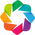

In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import seaborn
import numpy as np
import gsw
seaborn.set(font_scale=2)
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,7)
from IPython.display import SVG, display, Image, display_svg
import holoviews as hv
hv.extension('bokeh')

## ARGO Data ##

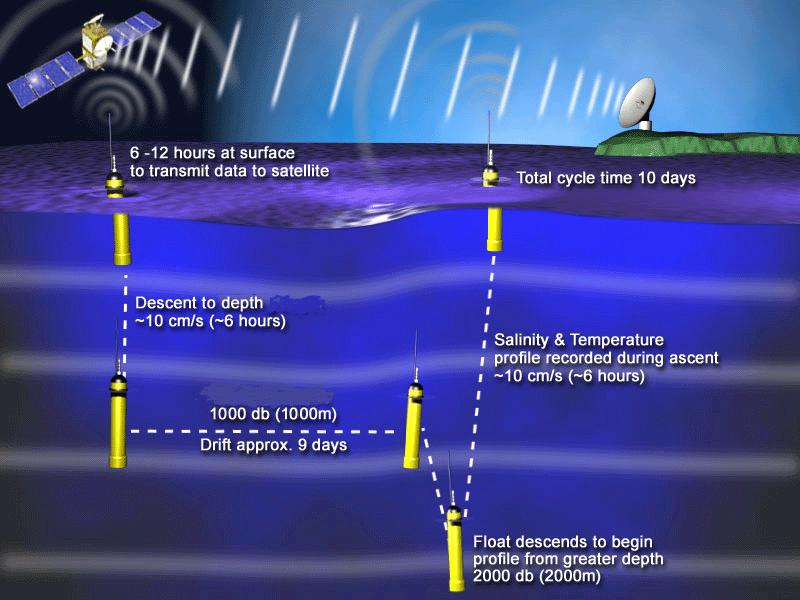

In [2]:
Image('http://www.argo.ucsd.edu/operation_park_profile.jpg')

In [3]:
# argo data available via opendap here
# http://data.nodc.noaa.gov/opendap/argo/data/contents.html
argo = xr.open_dataset('http://data.nodc.noaa.gov/opendap/argo/data/atlantic/2015/09/nodc_D1901358_079.nc')
argo = argo.isel(n_prof=0)
argo

<xarray.Dataset>
Dimensions:                       (n_calib: 1, n_history: 4, n_levels: 77, n_param: 3)
Dimensions without coordinates: n_calib, n_history, n_levels, n_param
Data variables:
    data_type                     object ...
    format_version                object ...
    handbook_version              object ...
    reference_date_time           object ...
    date_creation                 object ...
    date_update                   object ...
    direction                     object ...
    data_mode                     object ...
    juld_qc                       object ...
    position_qc                   object ...
    profile_pres_qc               object ...
    profile_temp_qc               object ...
    profile_psal_qc               object ...
    crs                           int32 ...
    platform_number               object ...
    project_name                  object ...
    pi_name                       object ...
    station_parameters            (n_param) ob

In [4]:
s_a = gsw.SA_from_SP(argo.psal, argo.pres, argo.longitude, argo.latitude).squeeze()
c_t = gsw.CT_from_t(s_a, argo.temp, argo.pres).squeeze()

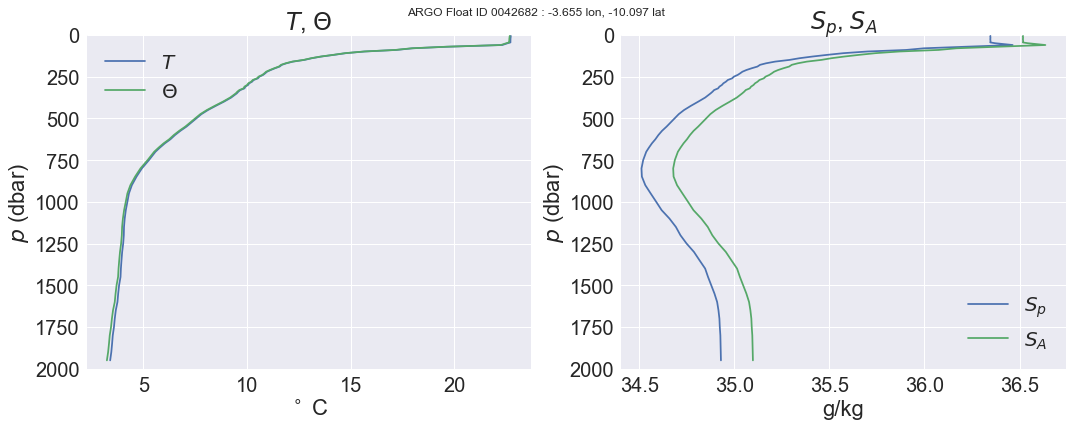

In [5]:
fig, ax = plt.subplots(ncols=2, figsize=(15,6))
ax[0].plot(argo.temp, argo.pres, label='$T$')
ax[0].plot(c_t, argo.pres, label=r'$\Theta$')
ax[0].set_xlabel(r'$^\circ$ C')
ax[0].set_title(r'$T$, $\Theta$')

ax[1].plot(argo.psal, argo.pres, label=r'$S_p$')
ax[1].plot(s_a, argo.pres, label=r'$S_A$')
ax[1].set_xlabel('g/kg')
ax[1].set_title(r'$S_p$, $S_A$')

[a.set_ylim([2000,0]) for a in ax]
[a.set_ylabel(r'$p$ (dbar)') for a in ax]
[a.legend() for a in ax]
fig.suptitle('ARGO Float ID %s : %g lon, %g lat' % (argo.id, argo.longitude, argo.latitude))
plt.tight_layout()

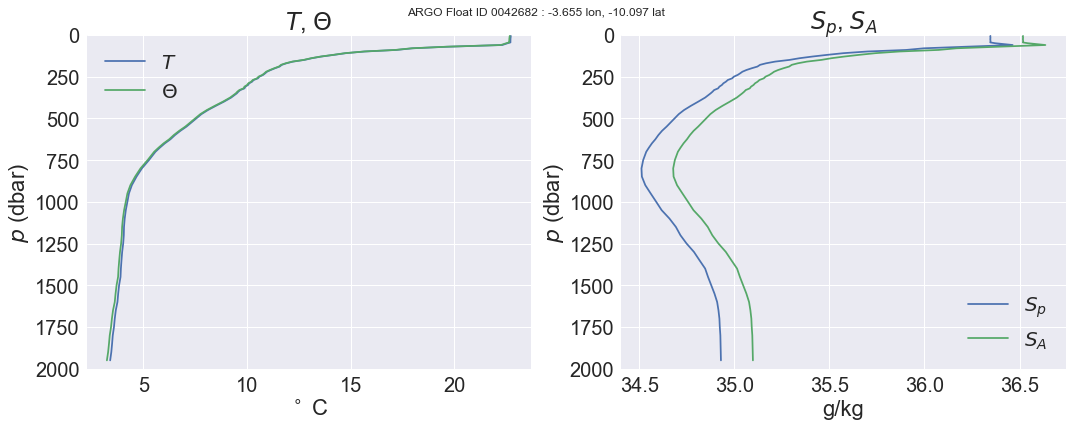

In [6]:
fig

## Temperature - Salinity Relationship

Used to identify water mass properties.

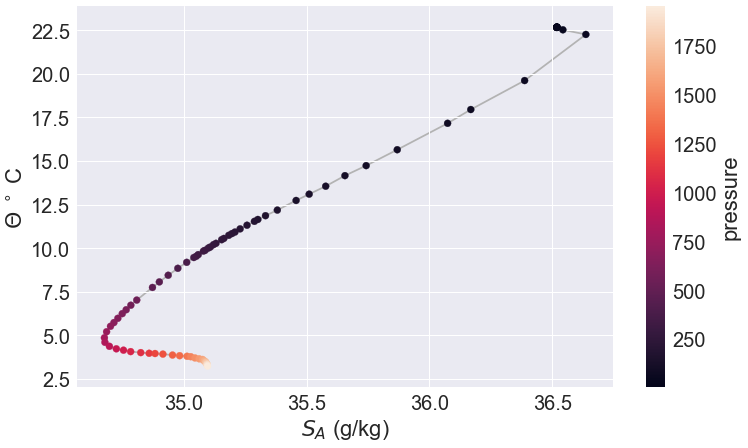

In [7]:
fig, ax = plt.subplots()
plt.plot(s_a, c_t, c='0.7', zorder=-999)
scat = ax.scatter(s_a, c_t, c=argo.pres)
ax.set_xlabel(r'$S_A$ (g/kg)')
ax.set_ylabel(r'$\Theta$ $^\circ$ C')
plt.colorbar(scat, label='pressure')

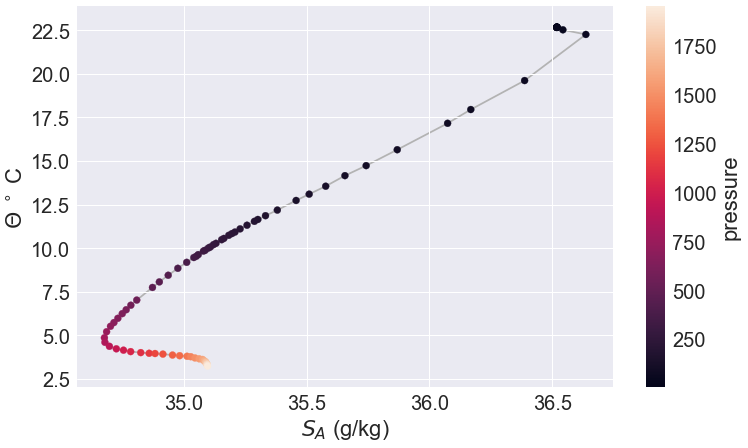

In [8]:
fig

In [9]:
rho = gsw.rho(s_a, c_t, argo.pres)
sig0 = gsw.sigma0(s_a, c_t)
sig2 = gsw.sigma2(s_a, c_t)
sig4 = gsw.sigma4(s_a, c_t)
Nsquared, p_mid = gsw.Nsquared(s_a, c_t, argo.pres)

## Buoyancy ##

A water parcel experiences a __buoyancy force__ if its density differs from the ambient density.

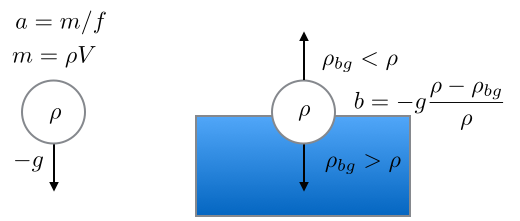

In [10]:
Image("02_images/buoyancy.png")

## Static Stability ##

Static stability measures how quickly a water parcel is restored to its position in the water column if it is displaced vertically. If the stability is negative, the water column has the potential to overturn.

An obvious, but slightly flawed, measure of stability would be

$$ -\frac{g}{\rho} \frac{\partial \rho}{\partial z} $$

_Question:_ What is wrong with this definition?

## Density Profile

In-situ density $\rho(S_A, \Theta, p)$ is not actually very informative about buoyacy because it mostly shows the adiabatic compressibility of seawater.


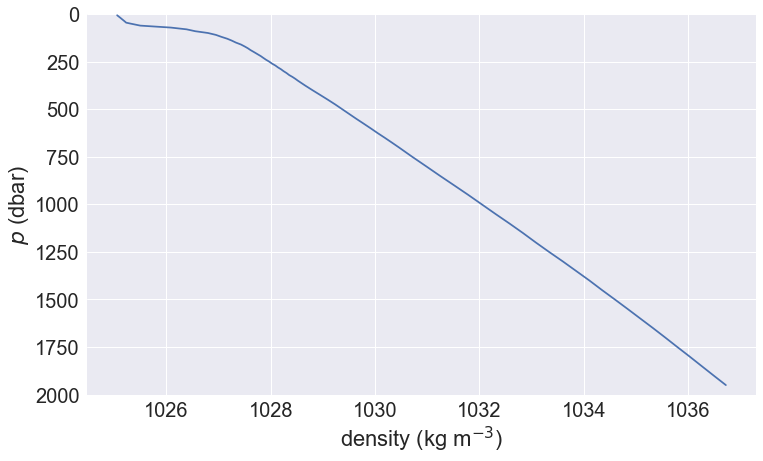

In [11]:
fig, ax = plt.subplots()
ax.plot(rho, argo.pres)
ax.set_ylim([2000, 0])
ax.set_ylabel(r'$p$ (dbar)')
ax.set_xlabel(r'density (kg m$^{-3}$)')

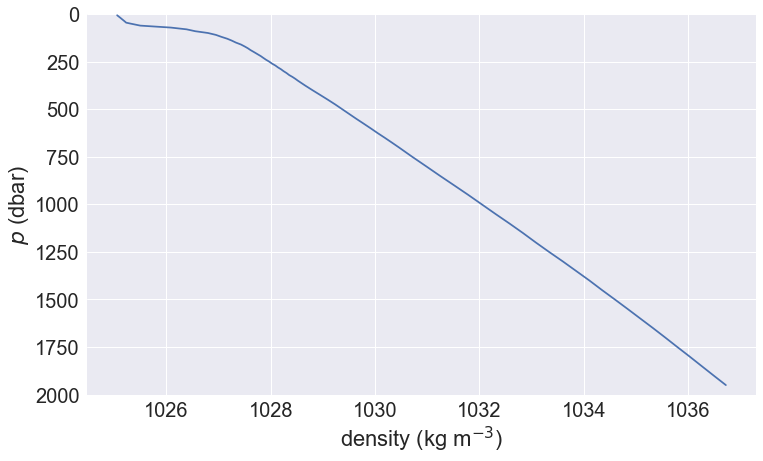

In [12]:
fig

## Buoyancy Frequency ##

The problem with the previous definition of stability is that it doesn't account for the adiabatic compressibility of water. If a parcel is displaced vertically, its pressure will change, causing a change in density. We need to subtract this effect.

$$ N^2 = -g \left ( \frac{1}{\rho}\frac{\partial \rho}{\partial z} + \kappa \frac{\partial p}{\partial z} \right )
= g(\alpha^\Theta \frac{\partial \Theta}{\partial z} - \beta^\Theta \frac{\partial S_A}{\partial z}) $$

$N$ is called the __buoyancy frequency__ because a displaced parcel will oscillated with frequency $N$. This type of oscillation is called an __internal wave__. If $N^2$ is negative, the water column is unstable and will overturn.


/Users/rpa/miniconda3/envs/geo_scipy/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


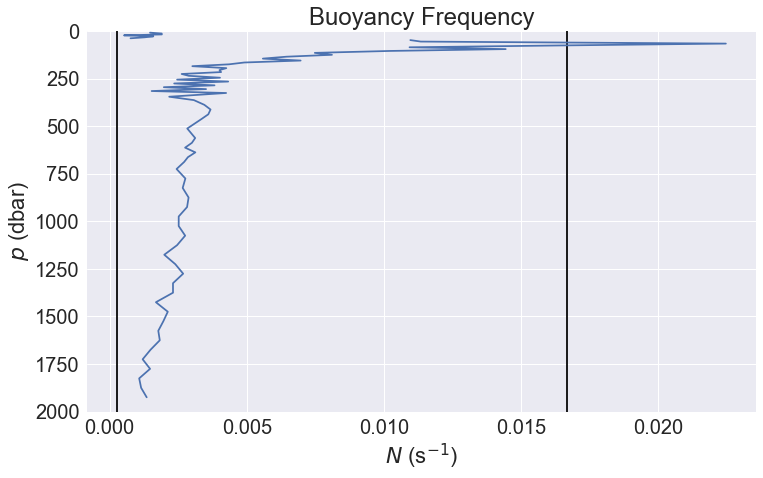

In [13]:
fig, ax = plt.subplots()
ax.plot(Nsquared**0.5, p_mid)
ax.set_xlabel(r's$^{-2}$')
ax.set_title('Buoyancy Frequency')
ax.vlines(60**-1, 2000, 0, label='1 minute')
ax.vlines((60*60)**-1, 2000, 0, label='1 hour')
ax.set_ylim([2000, 0])
ax.set_ylabel(r'$p$ (dbar)')
ax.set_xlabel(r'$N$ (s$^{-1}$)')

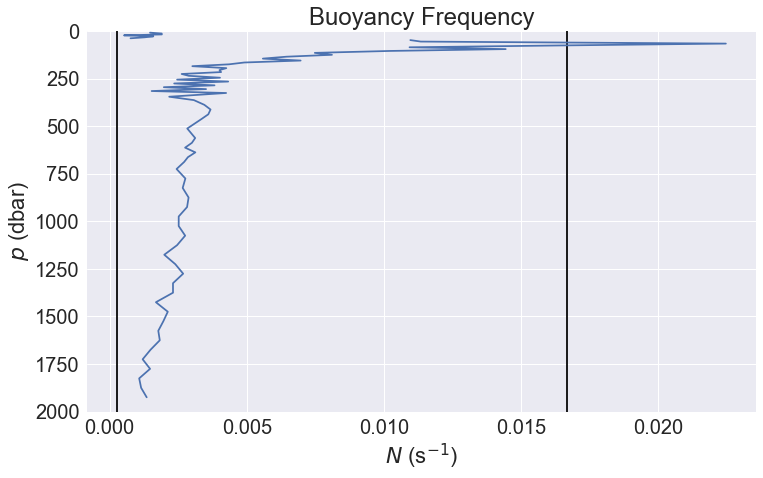

In [14]:
fig

## Potential Density ##

To eliminate the effect of adiabatic compressibility, we can calculate the denisty the water _would have_ if brought to some reference pressure $p_{ref}$. This is called **potential density**, defined as

$$
\sigma = \rho(S_A, \Theta, p_{ref})
$$

Because $\sigma$ is only a function of quasi-conservative quantities ($S_A$ and $\Theta$) it is itself quasi-conservative.

Near the reference pressure, it is the case that
$$
N^2 \simeq -\frac{g}{\rho} \frac{\partial \sigma}{\partial z}
$$
but, due to the nonlinearity in the equation of state, this is **not true** far from the reference pressure.

It is common to denote the reference pressure using a subscript: $\sigma_0$ (0 dbar), $\sigma_2$ (2000 dbar), and $\sigma_4$ (4000 dbar).

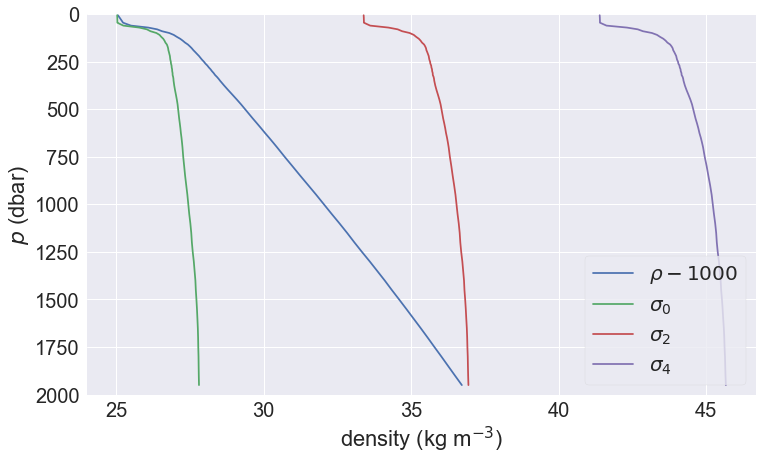

In [15]:
fig, ax = plt.subplots()
ax.plot(rho-1000, argo.pres, label=r'$\rho - 1000$')
ax.plot(sig0, argo.pres, label=r'$\sigma_0$')
ax.plot(sig2, argo.pres, label=r'$\sigma_2$')
ax.plot(sig4, argo.pres, label=r'$\sigma_4$')
ax.set_ylim([2000, 0])
ax.set_ylabel(r'$p$ (dbar)')
ax.set_xlabel(r'density (kg m$^{-3}$)')
ax.legend(frameon=True, loc='lower right')

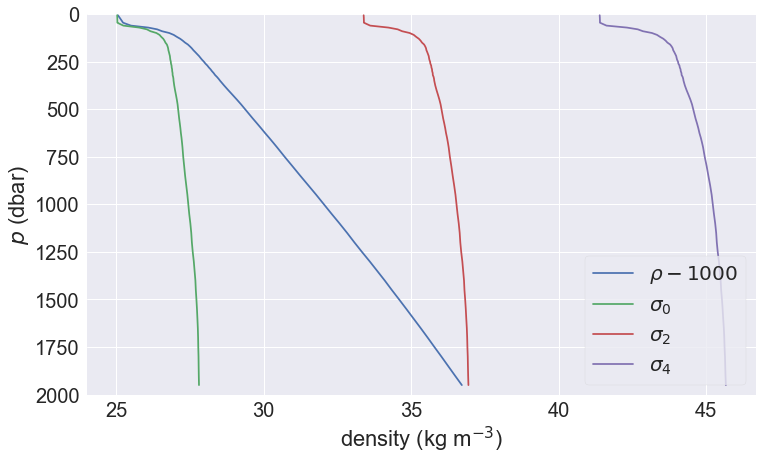

In [16]:
fig

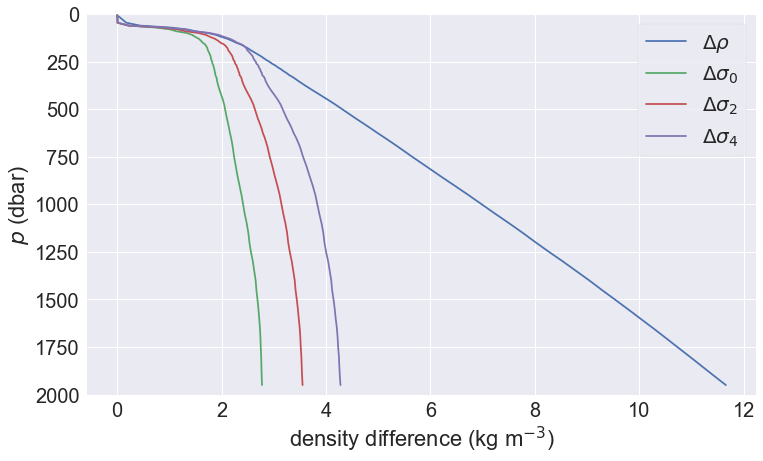

In [17]:
fig, ax = plt.subplots()
ax.plot(rho-rho[0], argo.pres, label=r'$\Delta \rho$')
ax.plot(sig0 - sig0[0], argo.pres, label=r'$\Delta \sigma_0$')
ax.plot(sig2 - sig2[0], argo.pres, label=r'$\Delta \sigma_2$')
ax.plot(sig4 - sig4[0], argo.pres, label=r'$\Delta \sigma_4$')
ax.set_ylim([2000, 0])
ax.set_ylabel(r'$p$ (dbar)')
ax.set_xlabel(r'density difference (kg m$^{-3}$)')
ax.legend(frameon=True, loc='upper right')

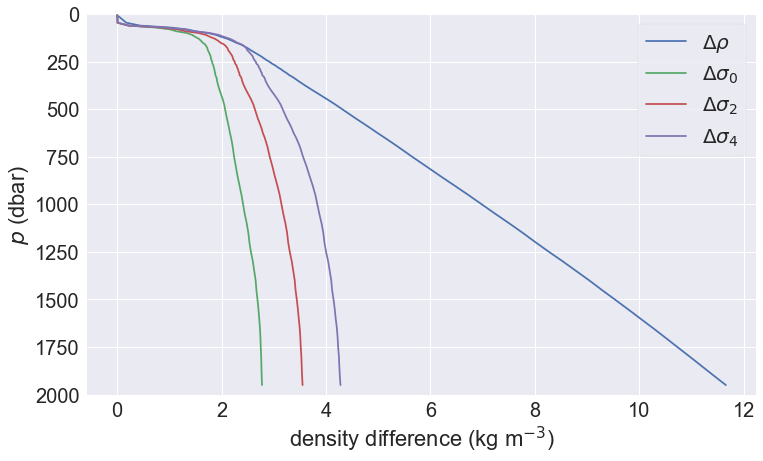

In [18]:
fig